# Libraries

In [1]:
import requests
import os
import yaml
os.chdir('../')

In [2]:
import datetime

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
params = {'legend.fontsize': 14,
          'figure.figsize': (15, 8),
         'axes.labelsize': 14,
         'axes.titlesize': 14,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
plt.rcParams.update(params)
pd.options.display.max_columns = 50
pd.options.display.precision = 2

In [5]:
from cloudant.view import View
from cloudant.client import Cloudant
from cloudant.document import Document

In [6]:
def unfold_keys(df):
    df = df.copy()
    key_column = 'key'
    for i in range(0, len(df.loc[0,key_column])):
        df.insert(i, 'level_{}'.format(i+1), df[key_column].apply(lambda x: x[i]))
    del df[key_column]
    return df

In [7]:
with open("config.yaml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile)

In [8]:
cfg = cfg['COUCHDB']
client = Cloudant(cfg['user'], cfg['password'], url=cfg['host'])
client.connect()
tweets_db = client[cfg['tweets_db']]
aurin_db = client[cfg['aurin_db']]

i = 0
for document in tweets_db:
    break
    if document.json()[0] != '{':
        print(document)
    i += 1
    if divmod(i, 10000)[1] == 0:
        print(i)

# Load data

In [9]:
def preprocess_view_data(df):
    geo_sentiment_columns = ['sa4_area', 'gccsa_area', 'state', 'sentiment', 'date', 'tweets_count']
    data_df = unfold_keys(df)
    #data_df.dropna(inplace=True)
    data_df.columns = geo_sentiment_columns
    data_df['date'] = data_df['date'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y')).astype(str)
    data_df.sort_values('tweets_count', ascending=False, inplace=True)
    data_df = data_df[~(data_df.state == 'Other Territories')]
    data_df.set_index(geo_sentiment_columns[:-1], inplace=True)
    return data_df

In [10]:
def get_sentiment_df(data, level):
    df = data.unstack(level='sentiment', fill_value=0)
    df = df.groupby(level=level).sum()
    df.columns = df.columns.droplevel(0)
    sorted_columns = list(df.sum().sort_values(ascending=False).index.values)
    df = df[sorted_columns]
    return df

## Load all tweets stat

In [11]:
ddoc = Document(tweets_db, '_design/sentiment_analysis')
view = View(ddoc, 'geo_sentiment_counts', )
with view.custom_result(group=True, stale='update_after') as rslt:
    df = pd.DataFrame.from_records(rslt.all())

In [12]:
df['value'].sum()

1132300

In [13]:
data_df = preprocess_view_data(df)
gccsa_sentiment_df = get_sentiment_df(data_df, 'gccsa_area')
sa4_sentiment_df = get_sentiment_df(data_df, 'sa4_area')

## Load topic tweets stat

In [14]:
ddoc = Document(tweets_db, '_design/topics')
view = View(ddoc, 'blockchain-all-stat', )
with view.custom_result(group=True, stale='update_after') as rslt:
    df = pd.DataFrame.from_records(rslt.all())

In [15]:
df['value'].sum()

1817

In [16]:
topic_data_df = preprocess_view_data(df)
topic_gccsa_sentiment_df = get_sentiment_df(data_df, 'gccsa_area')
topic_sa4_sentiment_df = get_sentiment_df(data_df, 'sa4_area')

## Load Aurin Data

### SA4 Median Income

In [17]:
data = [item['properties'] for item in aurin_db['SA4_median_income']['features']]
sa4_median_income_df = pd.DataFrame.from_records(data).set_index('sa4_name16')
del sa4_median_income_df['sa4_code16']
#sa4_median_income_df.head()

### SA4_Labour_Force

In [18]:
data = [item['properties'] for item in aurin_db['SA4_Labour_Force']['features']]
sa4_labour_force_df = pd.DataFrame.from_records(data).set_index('sa4_name16')
del sa4_labour_force_df['sa4_code16']
#sa4_labour_force_df.head()

### GCCSA Median Income

In [19]:
data = [item['properties'] for item in aurin_db['GCCSA_median_income']['features']]
gccsa_median_income_df = pd.DataFrame.from_records(data).set_index('gcc_name16')
del gccsa_median_income_df['gcc_code16']
#gccsa_median_income_df

### GCCSA_Labour_Force

In [20]:
data = [item['properties'] for item in aurin_db['GCCSA_Labour_Force']['features']]
gccsa_labour_force_df = pd.DataFrame.from_records(data).set_index('gcc_name16')
del gccsa_labour_force_df['gcc_code16']
#gccsa_labour_force_df

## GCCSA Data

In [21]:
gccsa_df = gccsa_sentiment_df.join(gccsa_median_income_df).join(gccsa_labour_force_df)
gccsa_df.to_csv('gccsa.csv')

In [22]:
topic_gccsa_df = topic_gccsa_sentiment_df.join(gccsa_median_income_df).join(gccsa_labour_force_df)
topic_gccsa_df.to_csv('topic_gccsa.csv')

## SA4 Data

In [23]:
sa4_df = sa4_sentiment_df.join(sa4_median_income_df).join(sa4_labour_force_df)
sa4_df.to_csv('sa4.csv')

In [24]:
topic_sa4_df = topic_sa4_sentiment_df.join(sa4_median_income_df).join(sa4_labour_force_df)
topic_sa4_df.to_csv('topic_sa4.csv')

# Visualisations

In [25]:
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
plotly.offline.init_notebook_mode(connected=True)

## Tweets by States

In [26]:
plot_df = data_df.groupby(level='state').sum().sort_values('tweets_count', ascending=False)

In [27]:
labels = plot_df.index.values.tolist()
values = plot_df.values.ravel().tolist()
trace = go.Pie(labels=labels, values=values, 
               hoverinfo='label+percent', sort=True, showlegend=False,
               textinfo='value+label', textposition='outside')
layout = go.Layout(title='Number of Collected Tweets by States')
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig, filename='basic_pie_chart')

In [28]:
plot_df = topic_data_df.groupby(level='state').sum().sort_values('tweets_count', ascending=False)

In [29]:
labels = plot_df.index.values.tolist()
values = plot_df.values.ravel().tolist()
trace = go.Pie(labels=labels, values=values, 
               hoverinfo='label+percent', sort=True, showlegend=False,
               textinfo='value+label', textposition='outside')
layout = go.Layout(title='Number of Collected Topic Tweets by States')
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig, filename='basic_pie_chart')

In [30]:
def plot_area_chart(plot_df, graph_title):
    button_masks = []
    data = []
    territories = plot_df.columns.get_level_values(0).unique()
    for idx, territory in enumerate(territories):
        mask = np.zeros(territories.shape[0]*(len(sentiment_columns)+1))
        territory_df = plot_df[territory][sentiment_columns]


        cols = []
        for jdx, col in enumerate(territory_df.columns):
            cols.append(col)
            trace = go.Scatter(
                x=territory_df.index.values,
                y=territory_df[cols].sum(axis=1).values.ravel(),
                text=territory_df[col],
                hoverinfo='x+text',
                fill='tonexty',
                visible=(idx==0),
                fillcolor=sentiment_colors[col],
                line = dict(color = sentiment_colors[col]),
                name=col,
            )
            data.append(trace)
            mask[idx*(len(sentiment_columns)+1) + jdx] = 1
        dummy_trace = go.Scatter(x=[None], y=[None], name='<b>Tweet Sentiment</b>', visible=(idx==0),
                                line={'color': 'rgba(0, 0, 0, 0)'})
        data.append(dummy_trace)
        mask[idx*(len(sentiment_columns)+1) + len(sentiment_columns)] = 1

        button_masks.append(list(mask==1))

    buttons = []
    for idx, mask in enumerate(button_masks):
        button = dict(
            label = territories[idx],
            method = 'update',
            args = [{'visible': mask},
                    {'title': '{} in {}'.format(graph_title, territories[idx])}],
        )
        buttons.append(button)
    updatemenus = list([dict(showactive = False,
                             buttons=buttons,

                             x = 0.01, xanchor = 'left',
                             y = 1.0,
                             yanchor = 'top',)])

    layout = go.Layout(title=graph_title,
                       xaxis=dict(title='Tweet Creation Date'),
                       yaxis=dict(title='Number of Collected Tweets'),
                       updatemenus=updatemenus,
                      )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig,filename='basic-area')

## Tweets by Sentiment, GCCSA Area and Time

In [54]:
sentiment_columns = ['Positive', 'Neutral', 'Negative']
sentiment_colors = {'Positive': 'rgb(120,220,120)', 'Negative':'rgb(245,99,99)', 'Neutral': 'rgb(250,250,150)'}

In [58]:
def add_missed_columns(df):
    l0_values, l1_values  = df.columns.levels
    mask = np.ones((l0_values.shape[0], l1_values.shape[0]), dtype=int)
    mask[df.columns.labels] = 0
    l0,l1 = mask.nonzero()
    for i, j in zip(l0, l1):
        df[l0_values[i],l1_values[j]] = 0
    return df.sort_index(axis=1, level=0)

In [59]:
def transform_df(df):
    group_columns = ['date', 'gccsa_area', 'sentiment']
    plot_df = df.groupby(level=group_columns).sum().unstack(level=['gccsa_area','sentiment'], fill_value=0)
    plot_df = plot_df.loc['2018-04-01':]
    plot_df.columns = plot_df.columns.droplevel(0)
    plot_df = add_missed_columns(plot_df)
    plot_df.sort_index(level=0, axis=1, inplace=True)

    temp_df = plot_df.groupby(axis=1, level='sentiment').sum()
    for col in sentiment_columns:
        plot_df.insert(0, ('All Austalia', col), temp_df[col])
    return plot_df

In [60]:
plot_area_chart(transform_df(data_df), graph_title = 'Number of Tweets by Creation Date')

In [62]:
plot_area_chart(transform_df(topic_data_df), graph_title = 'Number of Topic Tweets by Creation Date')

In [33]:
tweets_by_dates = topic_data_df.groupby(level='date').sum()
plot_df = tweets_by_dates.loc['2018-04-01':]

In [34]:
trace = go.Scatter(
    x=plot_df.index.values,
    y=plot_df.values.ravel(),
    fill='tozeroy'
)
layout = go.Layout(title='Number of Collected Topic Tweets by Tweet\'s Creation Date',
                   xaxis=dict(title='Tweet Creation Date'),
                    yaxis=dict(title='Number of Tweets'),)
fig = go.Figure(data=[trace], layout=layout)
plotly.offline.iplot(fig,filename='basic-area')

# Sentiment By States

In [35]:
sa4_sentiment_df.head()

sentiment,Neutral,Positive,Negative,nan
sa4_area,,,,
Adelaide - Central and Hills,4014,3576,778,41
Adelaide - North,776,792,179,12
Adelaide - South,16521,17211,7321,228
Adelaide - West,859,643,132,5
Australian Capital Territory,8859,8975,3274,51


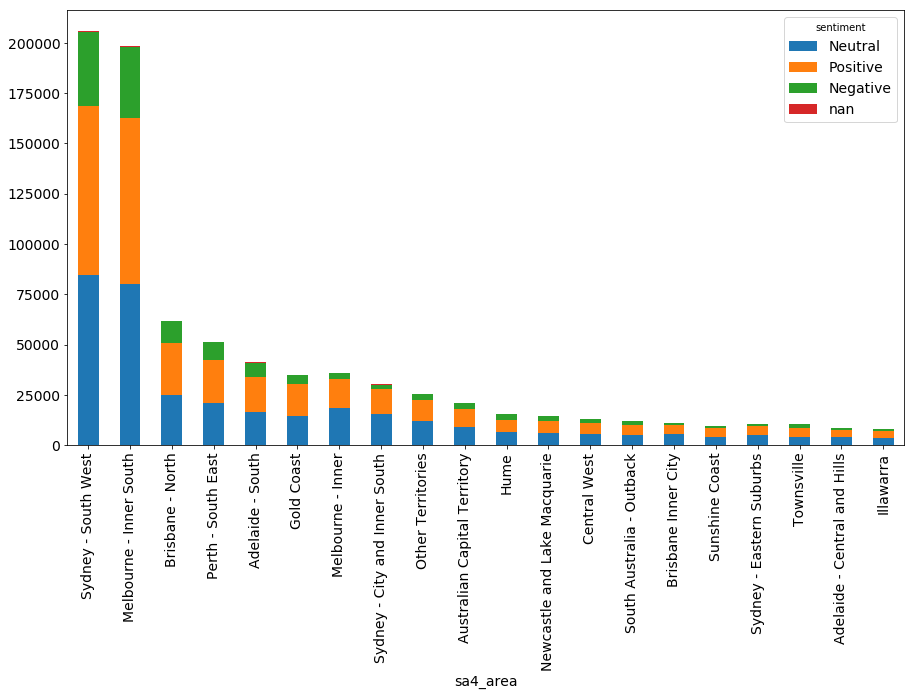

In [36]:
plot_df = sa4_sentiment_df.sort_values('Positive', ascending=False).iloc[:20]
plot_df.plot.bar(stacked=True)
plt.show()

In [37]:
totals = plot_df.sum(axis=1)
for idx in plot_df.index.values:
    plot_df.loc[idx] = plot_df.loc[idx] / totals.loc[idx] 

In [38]:
plot_df

sentiment,Neutral,Positive,Negative,nan
sa4_area,,,,
Sydney - South West,0.41,0.41,0.18,2.22e-03
Melbourne - Inner South,0.41,0.42,0.18,2.05e-03
Brisbane - North,0.41,0.42,0.17,2.40e-03
Perth - South East,0.41,0.42,0.17,1.64e-03
Adelaide - South,0.40,0.42,0.18,5.52e-03
Gold Coast,0.41,0.46,0.13,1.49e-03
Melbourne - Inner,0.52,0.40,0.08,8.89e-04
Sydney - City and Inner South,0.52,0.40,0.08,1.69e-03
Other Territories,0.47,0.41,0.11,3.13e-03


In [39]:
#* 100

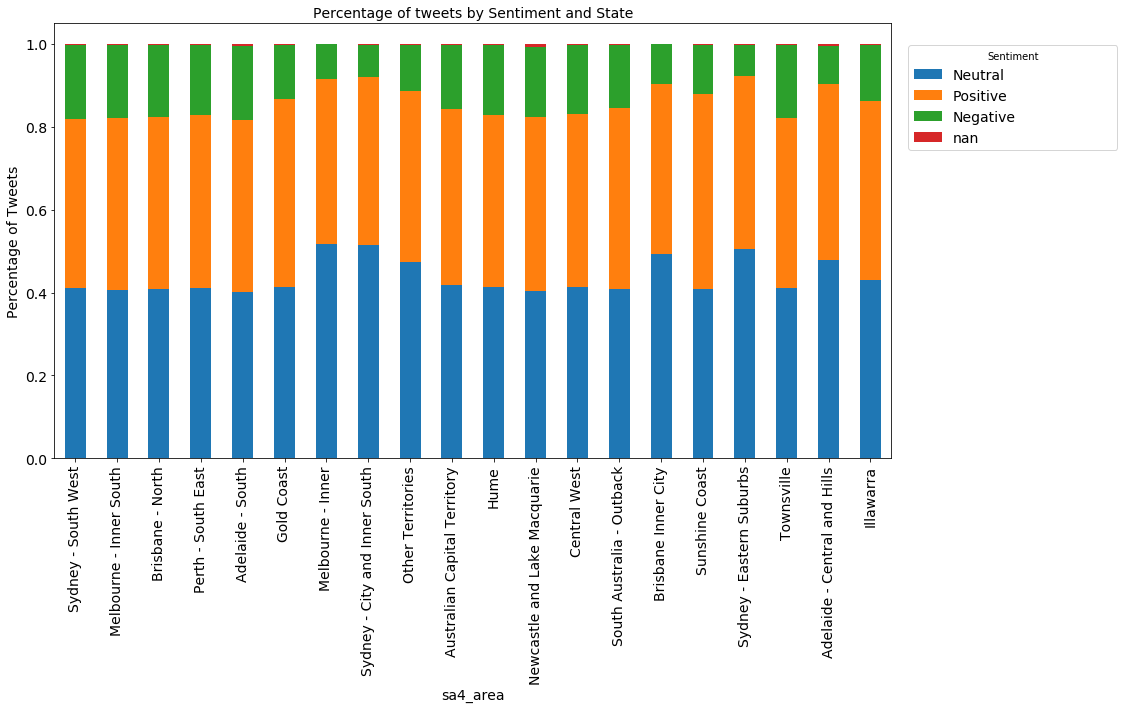

sentiment,Neutral,Positive,Negative,nan
sa4_area,,,,
Sydney - South West,41%,41%,18%,0%
Melbourne - Inner South,41%,42%,18%,0%
Brisbane - North,41%,42%,17%,0%
Perth - South East,41%,42%,17%,0%
Adelaide - South,40%,42%,18%,1%
Gold Coast,41%,46%,13%,0%
Melbourne - Inner,52%,40%,8%,0%
Sydney - City and Inner South,52%,40%,8%,0%
Other Territories,47%,41%,11%,0%


In [40]:
plot_df.plot.bar(stacked=True)
ax = plt.gca()
ax.legend(frameon=True, loc=2, bbox_to_anchor=(1.02, 0.0,.25, .95), mode='expand', borderaxespad=0.,
                      title='Sentiment')
ax.set_title('Percentage of tweets by Sentiment and State')
ax.set_ylabel('Percentage of Tweets')
plt.show()
plot_df.applymap(lambda x: '{:.0f}%'.format(x*100))

## Plotly plots

In [41]:
mapbox_access_token = 'pk.eyJ1Ijoidml0YWx5LXlha3V0ZW5rbyIsImEiOiJjamd3ZGJpMTQwcDA2MzNsNjg2dTJzeG1zIn0.shxkPXdNpbwF1UI2Gm24fg'

In [42]:
sa4_points_df = pd.read_json('notebooks/sa4_center.json')
sa4_points_df.set_index('SA4_name', inplace=True)
sa4_points_df['lat'] = sa4_points_df.Centre.apply(lambda x: x[0][1])
sa4_points_df['lng'] = sa4_points_df.Centre.apply(lambda x: x[0][0])
del sa4_points_df['Centre']

In [43]:
sa4_df = sa4_df.join(sa4_points_df)

In [44]:
sa4_df.head()

,Neutral,Positive,Negative,nan,median_tot_fam_inc_weekly,median_tot_prsnl_inc_weekly,p_tot_emp_tot,p_tot_lf_tot,p_tot_unemp_tot,p_unem_look_ptw_tot,lat,lng
sa4_area,,,,,,,,,,,,
Adelaide - Central and Hills,4014,3576,778,41,1967,700,137691,147027,9332,4751,-34.97,138.84
Adelaide - North,776,792,179,12,1407,563,180185,198775,18591,7125,-34.69,138.66
Adelaide - South,16521,17211,7321,228,1622,635,164500,176840,12341,5512,-35.14,138.57
Adelaide - West,859,643,132,5,1554,597,104681,113466,8786,3737,-34.87,138.53
Australian Capital Territory,8859,8975,3274,51,2445,1000,205419,215586,10167,5305,-35.49,149.00


In [45]:
scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]
#colorscale='Viridis'

data = [ dict(
        type = 'scattergeo',
        lat=sa4_df.lat,
        lon=sa4_df.lng,
        text =sa4_df.index.values,
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = 0,
            color = sa4_df['Positive'],
            cmax = sa4_df['Positive'].max(),
            colorbar=dict(
                title="Positive Sentiment Count"
            )
        )
        )]

layout = dict(
        #title = 'Most trafficked US airports<br>(Hover for airport names)',
        colorbar = True,
    width=1000,
    height=900,
    margin=go.Margin(l=10, r=10, b=10, t=10, pad=4
    ),
        geo = dict(
            #domain=dict(x=[0,3], y=[-1,1]),
            resolution=50,
            projection = dict( type = 'Mercator'),
            lataxis=dict(range=[-45.0, -5.0]),
            lonaxis=dict(range=[110.0, 155.0] ),
                        
            showland = True,
            showcountries=True,
            showsubunits=True,
            
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
        ),
    )

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False, filename='' )

In [46]:
sa4_df

,Neutral,Positive,Negative,nan,median_tot_fam_inc_weekly,median_tot_prsnl_inc_weekly,p_tot_emp_tot,p_tot_lf_tot,p_tot_unemp_tot,p_unem_look_ptw_tot,lat,lng
sa4_area,,,,,,,,,,,,
Adelaide - Central and Hills,4014,3576,778,41,1967,700,137691,147027,9332,4751,-34.97,138.84
Adelaide - North,776,792,179,12,1407,563,180185,198775,18591,7125,-34.69,138.66
Adelaide - South,16521,17211,7321,228,1622,635,164500,176840,12341,5512,-35.14,138.57
Adelaide - West,859,643,132,5,1554,597,104681,113466,8786,3737,-34.87,138.53
Australian Capital Territory,8859,8975,3274,51,2445,1000,205419,215586,10167,5305,-35.49,149.00
Ballarat,1847,1721,816,9,1409,559,67396,72295,4899,2084,-37.38,143.73
Barossa - Yorke - Mid North,660,710,260,14,1318,535,45980,49147,3170,1111,-33.66,138.45
Bendigo,1663,1542,598,9,1443,593,66444,70699,4258,1897,-36.60,144.09
Brisbane - East,845,739,164,5,1902,717,108128,115073,6948,2904,-27.55,153.33


In [47]:
scl = [ [0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"] ]

data = [ dict(
        type = 'scattermapbox',
        lat=sa4_points_df.lat,
        lon=sa4_points_df.lng,
        text =sa4_points_df.index.values,
        mode = 'markers+text',
    

        marker=go.Marker(
            #symbol='square-15.svg',
            size = 12,
            opacity = 0.6,
            #reversescale = True,
            autocolorscale = False,
            #line = dict(width=1, color='rgba(102, 102, 102)'),
            colorscale = 'Viridis',
            cmin = 0,
            #color = sa4_df['Positive'],
            color = sa4_df['median_tot_prsnl_inc_weekly'],
            cmax = sa4_df['median_tot_prsnl_inc_weekly'].max(),
            colorbar=dict( title="Positive Sentiment")
            )
        )]

layout = dict(
        #title = 'Most trafficked US airports<br>(Hover for airport names)',
        colorbar = True,
    width=1000,
    height=850,
    margin=go.Margin(l=10, r=10, b=10, t=10, pad=4),
        mapbox=dict(
                    accesstoken=mapbox_access_token,
                    bearing=0,
                    center=dict(
                        lat=-28,
                        lon=134
                    ),
        pitch=0,
        zoom=3.8
    ),
    )

fig = dict( data=data, layout=layout )
plotly.offline.iplot( fig, validate=False, filename='' )